In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
color=sns.color_palette()
import xgboost as xgb
from  lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import roc_curve,average_precision_score,roc_auc_score,precision_recall_curve
import gc
from bayes_opt import BayesianOptimization
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.ensemble import GradientBoostingClassifier as gbc
from sklearn.ensemble import AdaBoostClassifier as abc
from sklearn.svm import SVC

In [2]:
def eval_func(clf,X,y,n_folds=5):
    eval_value=0
    kf=KFold(n_splits=5,shuffle=True,random_state=42)
    for i,(train_index,test_index) in enumerate(kf.split(X)):
        train_data,train_label=X[train_index],y[train_index]
        test_data,test_label=X[test_index],y[test_index]
        clf.fit(train_data,train_label)
        y_pred=clf.predict_proba(test_data)[:,1]
        eval_value+=roc_auc_score(test_label,y_pred)
    return eval_value/n_folds

In [3]:
def xgboost_classifier(n_estimators, min_child_weigth, colsample_bytree, max_depth,subsample, gamma, alpha):
    clf=xgb.XGBClassifier(n_estimators=int(n_estimators),
                         colsample_bytree=max(min(colsample_bytree, 1), 0),
                         max_depth=int(max_depth),
                         subsample= max(min(subsample, 1), 0),
                         gamma=max(gamma, 0),
                         reg_alpha = max(alpha, 0),
                         min_child_weight=int(min_child_weigth))
    return eval_func(clf,train,y)

In [24]:
def plot_imp_regular(clf):
    feature_importance=clf.feature_importances_#获取特征的重要性系数
    
    feature_importance=100.0*(feature_importance/feature_importance.max())#归一化到0-100
    sorted_idx=np.argsort(feature_importance)[:20]#获取数组从小到大排序的索引
    pos=np.arange(sorted_idx.shape[0])+.5
    feature_names=headers
    plt.barh(pos,feature_importance[sorted_idx],align='center')#设置水平条形图的属性，指标为重要性指数
    plt.yticks(pos,feature_names[sorted_idx],fontsize=15,family='SimHei')#显示y轴的刻度和每个刻度的名称
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')
    plt.show()

In [5]:
def train_model(data_, test_, y_, folds_):

    oof_preds = np.zeros(data_.shape[0])#训练集的输出结果
    sub_preds = np.zeros(test_.shape[0])#测试集的输出结果
    
    feature_importance_df = pd.DataFrame()
    
    for n_fold, (trn_idx, val_idx) in enumerate(folds_.split(data_)):
        trn_x, trn_y = data_[trn_idx],y_[trn_idx]
        val_x, val_y = data_[val_idx],y_[val_idx]
        clf = LGBMClassifier(
            nthread=4,
            #is_unbalance=True,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=32,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.04,
            reg_lambda=0.073,
            min_split_gain=0.0222415,
            min_child_weight=40,
            silent=-1,
            verbose=-1,
        )
        
        clf.fit(trn_x, trn_y, 
                eval_set= [(trn_x, trn_y), (val_x, val_y)], 
                eval_metric='auc', verbose=100, early_stopping_rounds=200  
               )
        
        oof_preds[val_idx] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_, num_iteration=clf.best_iteration_)[:, 1] / folds_.n_splits
        with open('./input_file/feats.pickle','rb') as f:
            feats=pickle.load(f)
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(val_y, oof_preds[val_idx])))
        del clf, trn_x, trn_y, val_x, val_y
        gc.collect()
        
    print('Full AUC score %.6f' % roc_auc_score(y, oof_preds)) 
    result=pd.DataFrame()
    with open('./input_file/testname.pickle','rb') as f:
        names=pickle.load(f)
    result['SK_ID_CURR']=names
    result['TARGET'] = sub_preds

    return oof_preds, result, feature_importance_df
    

def display_importances(feature_importance_df_):
    # Plot feature importances
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(
        by="importance", ascending=False)[:50].index#选取重要性排前50的特征进行展示
    
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    
    plt.figure(figsize=(8,10))
    sns.barplot(x="importance", y="feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('./result/lgbm_importances.png')


def display_roc_curve(y_, oof_preds_, folds_idx_):
    # Plot ROC curves
    plt.figure(figsize=(6,6))
    scores = [] 
    for n_fold, (_, val_idx) in enumerate(folds_idx_):  
        # Plot the roc curve
        fpr, tpr, thresholds = roc_curve(y_[val_idx], oof_preds_[val_idx])
        score = roc_auc_score(y_[val_idx], oof_preds_[val_idx])
        scores.append(score)
        plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.4f)' % (n_fold + 1, score))
    
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Luck', alpha=.8)
    fpr, tpr, thresholds = roc_curve(y_, oof_preds_)
    score = roc_auc_score(y_, oof_preds_)
    plt.plot(fpr, tpr, color='b',
             label='Avg ROC (AUC = %0.4f $\pm$ %0.4f)' % (score, np.std(scores)),
             lw=2, alpha=.8)
    
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('LightGBM ROC Curve')
    plt.legend(loc="lower right")
    plt.tight_layout()
    
    plt.savefig('./result/roc_curve.png')


def display_precision_recall(y_, oof_preds_, folds_idx_):
    # Plot ROC curves
    plt.figure(figsize=(6,6))
    
    scores = [] 
    for n_fold, (_, val_idx) in enumerate(folds_idx_):  
        # Plot the roc curve
        fpr, tpr, thresholds = roc_curve(y_[val_idx], oof_preds_[val_idx])
        score = average_precision_score(y_[val_idx], oof_preds_[val_idx])
        scores.append(score)
        plt.plot(fpr, tpr, lw=1, alpha=0.3, label='AP fold %d (AUC = %0.4f)' % (n_fold + 1, score))
    
    precision, recall, thresholds = precision_recall_curve(y_, oof_preds_)
    score = average_precision_score(y_, oof_preds_)
    plt.plot(precision, recall, color='b',
             label='Avg ROC (AUC = %0.4f $\pm$ %0.4f)' % (score, np.std(scores)),
             lw=2, alpha=.8)
    
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('LightGBM Recall / Precision')
    plt.legend(loc="best")
    plt.tight_layout()
    
    plt.savefig('./result/recall_precision_curve.png')


In [6]:
def xgboostModel(data,test,y,folds):
    train_predict=np.zeros(data.shape[0])
    sub_preds=np.zeros(test.shape[0])
    feature_importance_df=pd.DataFrame()
    for n_fold,(train_index,val_index) in enumerate(folds.split(data)):
        trainX,trainY=data[train_index],y[train_index]
        valX,valY=data[val_index],y[val_index]
        clf=xgb.XGBClassifier(n_estimators=4000,
                              colsample_bytree=.5,
                              max_depth=7,
                              subsample=.7,
                              gamma=5,
                              alpha=5,
                              eta=0.1
                             )
        clf.fit(trainX,trainY,eval_set=[(valX,valY)],
                eval_metric='auc',
                early_stopping_rounds=10,
                verbose=1)
        train_predict[val_index] = clf.predict_proba(valX)[:, 1]
        sub_preds += clf.predict_proba(test)[:, 1] / folds.n_splits
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valY, train_predict[val_index])))
        del clf, trainX, trainY, valX, valY
        gc.collect()
        
    print('Full AUC score %.6f' % roc_auc_score(y, train_predict)) 
    result=pd.DataFrame()
    with open('./input_file/testname.pickle','rb') as f:
        names=pickle.load(f)
    result['SK_ID_CURR']=names
    result['TARGET'] = sub_preds

    return train_predict, result, feature_importance_df

In [7]:
# gc.enable()
# folds = KFold(n_splits=5, shuffle=True, random_state=546789)
# oof_preds, test_preds, importances = train_model(train, test, y, folds)
# test_preds.to_csv('lgbm_submission.csv', index=False)

In [7]:
train,test,y=np.load('./input_file/train.npy'),np.load('./input_file/test.npy'),np.load('./input_file/label.npy')

In [9]:
def rf_classifier(data,test,label,folds):
    train_predict=np.zeros(data.shape[0])
    sub_preds=np.zeros(test.shape[0])
    for n_fold,(train_index,test_index) in enumerate(folds.split(data)):
        train_x,train_y=data[train_index],y[train_index]
        val_x,val_y=data[val_index],y[val_index]
        

In [9]:
def lgbm_classifier(n_estimators,learning_rate,num_leaves,colsample_bytree,subsample,max_depth,reg_alpha,reg_gamma,min_split_gain,min_child_weight):
    clf=LGBMClassifier(n_estimators=int(n_estimators),
                          learning_rate=learning_rate,
                          num_leaves=int(num_leaves),
                          colsample_bytree=colsample_bytree,
                          subsample=subsample,
                          max_depth=int(max_depth),
                          reg_alpha=reg_alpha,
                          reg_gamma=reg_gamma,
                          min_split_gain=min_split_gain,
                          min_child_weight=min_child_weight,
                          num_iterations=1000,
                          random_state=42)
    return eval_func(clf,train,y)

In [10]:
lgbmBO=BayesianOptimization(lgbm_classifier,
                               {'n_estimators':(10,13500),
                                'num_leaves':(5,200),
                                'colsample_bytree':(0,1),
                                'subsample':(0,1),
                                'max_depth':(5,50),
                                'reg_alpha':(0,1),
                                'reg_gamma':(0,1),
                                'min_child_weight':(1,120),
                                'learning_rate':(0.05,0.1),
                                'min_split_gain':(0,1)
                               })
lgbmBO.maximize()
params=lgbmBO.res['max']['max_params']
print('done')

Initialization
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   colsample_bytree |   learning_rate |   max_depth |   min_child_weight |   min_split_gain |   n_estimators |   num_leaves |   reg_alpha |   reg_gamma |   subsample | 
    1 | 02m15s |    0.77525 |             0.0224 |          0.0537 |     46.4169 |            82.7952 |           0.4425 |       426.9256 |      18.1713 |      0.9400 |      0.6600 |      0.2149 | 
    2 | 08m14s |    0.77792 |             0.9570 |          0.0551 |     38.9596 |            48.1356 |           0.5650 |     12105.4511 |      66.4632 |      0.4302 |      0.7706 |      0.8387 | 
    3 | 03m37s |    0.77800 |             0.3620 |          0.0802 |     14.6625 |            84.8846 |           0.5009 |      3547.4180 |      74.2093 |      0.8147 |      0.2657 |      0.7595

In [26]:
import pickle
with open('./result/lgbm_best.params.pickle','wb') as f:
    pickle.dump(params,f)

In [21]:
def showLightgbmResult(params):
    clf=LGBMClassifier(
        learning_rate=params['learning_rate'],
        max_depth=int(params['max_depth']),
        num_leaves=int(params['num_leaves']),
        colsample_bytree=params['colsample_bytree'],
        subsample=params['subsample'],
        min_split_gain=params['min_split_gain'],
        min_child_weight=int(params['min_child_weight']),
        reg_alpha=params['reg_alpha'],
        reg_gamma=params['reg_gamma'],
        n_estimators=int(params['n_estimators']),
        num_iterations=1000,
        random_state=42)
    clf.fit(train,y)
    plot_imp_regular(clf)

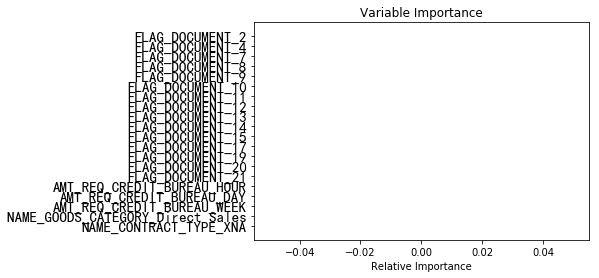

In [25]:
with open('./input_file/feats.pickle','rb')as f:
    headers=pickle.load(f)
showLightgbmResult(params)

In [ ]:
# xgBO=BayesianOptimization(xgboost_classifier,{'min_child_weigth': (1,120),
#                           'colsample_bytree':(0.1, 1),
#                           'max_depth':(5, 25),
#                           'subsample':(0.5, 1),
#                           'n_estimators':(10, 13500),
#                           'gamma':(0,10),
#                           'alpha':(0, 10)})
# xgBO.maximize()
# params=xgBO.res['max']['max_params']